<h1> Feature engineering <br>
Modelling <br>
and Evaluation</h2>
<br>
<br>
<b> This is work in progress! </b> <p> Next up is making the pipeline more automated. Scaling the targets. And finetune  the  LSTM, which architeture should it have. How many lags, how many LSTM units, how many  layers, how many perceptrons, which activation functions, and which special layers to add to the architecture. 
<br>
<br>
Radical change: use NIBOR in stead of interest rate, because it is update daily and can give better results.
<h4> Readying the forecast dataset </h4>
Use Ohrnstein Uhlenbeck process to find Food_index price. Use SSB/NB to find forecasts for policy rate. Find some forecasts or eventually use OU-process to find the FX.

<!-- <ol>
<li>Deterministic process</li>
<li>Lagged variables</li>
<li> Fourier</li>
<li>Seasonal indicators (very important)</li>
<li></li>
<li></li>
<li></li>
</ol> -->

<h1> 1. Getting started </h1>
<h2> 1.1 Importing libraries </h2>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

import random7
from keras import regularizers


import tensorflow as tf
from tensorflow import keras
from keras import Sequential, layers, Input, callbacks
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation
from keras.optimizers import RMSprop, Adam


from statsmodels.tsa.deterministic import DeterministicProcess
from statsmodels.tsa.deterministic import  CalendarFourier

from sklearn.metrics import mean_absolute_percentage_error as MAPE
from keras.callbacks import EarlyStopping


ModuleNotFoundError: No module named 'random7'

<h2> 1.2 Downloading data </h2>

In [5]:
df = pd.read_csv('Preprocessed_data.csv')
df.index = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.drop(['Date'], axis=1, inplace=True)

<h2> 1.3 Splitting data in 3*2 </h2>
<p> SPlitting data into train, test and validation with the following split: 70 | 15 |15.

In [6]:
y = df['Salmon_exp_vol']
X = df.loc[:,'FX_EURONOK':]

X_train, X_eval, y_train, y_eval = train_test_split(X,y, 
                                                    test_size=0.2,
                                                    shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_eval, y_eval, 
                                                test_size=0.5,
                                                shuffle=False)

<h1> 2. Feature engineering </h1>

<h2> 2.1 Manual imputing </h2>
<p>  Manually fixing NaN, and wrongful observations from the dataset in the training data. </p>

In [7]:
X_train['FX_EURONOK']['2002-10-14'] = 7.34
X_train['FX_EURONOK']['2008-08-04'] = 7.9995
X_train['FX_EURONOK']['2008-08-08'] = 7.9915
X_train['FX_EURONOK']['2008-08-11'] = 7.9975
X_train['FX_EURONOK']['2008-08-18'] = 7.9740

<h2> 2.2 Time dummy and Fourier  </h2>
<p> Creating a time dummy variable. Adding one new colum, where the value goes from 0 to the amount of observations. </p>

In [8]:
def det_process(X, startValue=None):
    # fourier0  =  CalendarFourier(freq='A',  order=3)
    # fourier1  =  CalendarFourier(freq='6M',  order=3)
    # fourier2  =  CalendarFourier(freq='Q',  order=3)

    dp = DeterministicProcess(
        index=X.index,
        constant=True,
        order=1,
        seasonal=True,
        # additional_terms=[fourier0,fourier1,fourier2],
        drop=True
    ) 
    dp = dp.in_sample()
    dp['trend'] += startValue
    new_X = pd.concat([X,dp], axis=1)
    return new_X
time_func = FunctionTransformer(func=det_process, 
                                kw_args={'startValue':None})


<h2> 2.3  Column specific engineering </h2>
<h3> 2.3.1 Log transformation </h3>
<p> Function for log transformation. The FOREX column shows specific characeristics from the lognormal distribution. 

In [9]:
def log_transformation(X):
    X = np.log1p(X)
    X = pd.DataFrame(X)
    return X
log_func = FunctionTransformer(func=log_transformation)

<h3> 2.3.2 Lagging variables </h3>
<p> Creating a function that create specific lagged variables for the datasets. Not going to use this function </p>

In [10]:
def lagged_func_org(X, target=None):
    X_new =  pd.concat([target, X], axis=1)
    # lags = [[1,2,3,4],[13],[1,5],[1,2,3,4]]
    # shift_cols = ['Salmon_exp_vol', 'Interest_rate', 'Food_index', 'FX_EURONOK']
    lags = [[1]]
    shift_cols = ['Salmon_exp_vol']

    sec_it = 0
    lagged_df = pd.DataFrame()
    for n_col in range(len(shift_cols)):
        for n_lag  in range(len(lags[n_col])):
            sec_it+=1
            lagged_df[str(shift_cols[n_col]+
                      '_lag'+
                      str(lags[n_col][n_lag]))] = X_new[shift_cols[n_col]].shift(lags[n_col][n_lag])
    ldf = pd.concat([X,lagged_df],axis=1).dropna()
    return ldf

lagged_func = FunctionTransformer(func=lagged_func_org, 
                                  kw_args={'target':None})

<h2> 2.4  Z-scoring </h2>
<p> Create functions for scaling the variables in a standardized way. </p>

In [11]:
zScore_func = StandardScaler()
zScoreTarget_func = StandardScaler()

<h2> 2.6 Seasonal indicators </h2>
<p> Creating dummy variables for each week in a year. So creating 52 new columns, on for each week. The values are 1 if the observations falls within that week, and zero if not. </p>

In [12]:
def seasonal_indicators(X):
    # weeks = [1,2,3,4,5,6,42,43,44,45,46,47,48,49,50,51,52]
    weeks = np.linspace(1,52,52)
    indicator_df = pd.DataFrame()
    for ind_week in range(len(weeks)):
        column = np.where(X.index.isocalendar().week==weeks[ind_week],1,0)
        indicator_df['IndWeek'+str(weeks[ind_week])] = column
    indicator_df.index = X.index
    new_X = pd.concat([X, indicator_df],axis=1)
    return new_X
indicator_func = FunctionTransformer(func=seasonal_indicators)



<h2> 2.5 Reshaping 2d->3d array </h2>
Function for reshaping the dataset to include timesteps, and transform the data from being 2d to 3d </p>

In [13]:
def reshaper(X, timeSteps=None):
    X = pd.DataFrame(X)
    new_Xs = [np.array(X[timeSteps:])]

    for i in range(1, timeSteps+1,1):
        shift_X  = np.array(X.shift(i))
        new_Xs.append(shift_X[timeSteps:])
    # for i in range(1,timeSteps+1,1):
    #     shift_X  = np.array(X.shift(-i))
    #     new_Xs.append(shift_X[timeSteps:])

    X_reshaped = np.stack(new_Xs, axis=1)
    print(X_reshaped.shape)
    return X_reshaped

reshape_func = FunctionTransformer(func=reshaper, kw_args={'timeSteps':None})

<h1> 3. LSTM model </h1>

In [14]:
import keras_tuner 
import keras

In [15]:
# np.random.seed(7)


# units = hp.Int(name='units', min_value=25, max_value= 250, step= 25)
# model = keras.Sequential([
#     layers.Input(shape=(14,109), name='input_layer'),
#     layers.LSTM(75, recurrent_dropout=0.5, return_sequences=True),
#     # layers.LSTM(150, recurrent_dropout=0.3, return_sequences=True),
#     # layers.LSTM(200, recurrent_dropout=0.3),
#     # layers.BatchNormalization(),
#     # layers.Dropout(0.5),
#     # layers.Dense(128, activation='relu'),
#     # layers.BatchNormalization(),
#     # layers.Dropout(0.3),
#     # layers.Dense(256, activation='relu'),
#     # layers.BatchNormalization(),
#     # layers.Dropout(0.5),
#     # layers.Dense(512, activation='gelu'),
#     # layers.Dropout(0.3),
#     # layers.Dense(256, activation='selu'),
#     # layers.Dropout(0.5),
#     layers.Dense(109, activation='relu'),
#     layers.Dense(1)
# ])


# optimizer = Adam(learning_rate=0.001)  # You can adjust the learning rate as needed
# model.compile(optimizer=optimizer,
#             #   loss=keras.losses.MeanSquaredError()
#               loss = 'mae'
#               )

# early_stopping = callbacks.EarlyStopping(
#     min_delta=0.001, 
#     patience=15, 
#     restore_best_weights=True,
# )

<h1> 4.  Pipelining </h1>
<h2> 4.1 Column specific pipeline </h2>

In [16]:
engineering_func = ColumnTransformer(
    transformers=[
        ('loger', log_func, ['FX_EURONOK']),
    ], remainder='passthrough')

<h2> 4.2 Total pipeline </h2>

In [17]:
X_val_corr = pd.concat([X_train[-15:],X_val])
X_test_corr = pd.concat([X_val[-15:],X_test])

In [18]:
pipe = Pipeline(steps=[
    ('det', time_func),
    ('ind', indicator_func),
    ('lag', lagged_func),
    ('Col_spec', engineering_func),
    ('zScore_func', zScore_func),
    ('res', reshape_func)
    # ('lstm', model)
])


pipe.set_params(
                det__kw_args={'startValue':0},
                lag__kw_args={'target':y_train},
                res__kw_args={'timeSteps':13}
                )
X_train_preprocessed  = pipe.fit_transform(X_train)

pipe.set_params(det__kw_args={'startValue':960}, 
                lag__kw_args={'target':y_val},
                res__kw_args={'timeSteps':13})
X_val_preprocessed  = pipe.transform(X_val_corr)

pipe.set_params(det__kw_args={'startValue':1080}, 
                lag__kw_args={'target': y_test},
                res__kw_args={'timeSteps':13})
X_test_preprocessed  = pipe.transform(X_test_corr)


(946, 14, 109)
(106, 14, 109)
(106, 14, 109)


In [19]:
# target_scaler = StandardScaler()
# y_train_pre = target_scaler.fit_transform(np.array([y_train[14:]]).T)
# y_val_pre = target_scaler.transform(np.array([y_val[14:]]).T)
# y_test_pre = target_scaler.transform(np.array([y_test[14:]]).T)

y_train_pre = y_train[14:]
y_val_pre = y_val[14:]
y_test_pre =y_test[14:]

<h1> X. Rest are drafts.. </h1>

In [20]:
# def rolling_window_cross_val(model, metric):
#     X = np.concatenate((X_train_preprocessed,X_val_preprocessed),axis=0)
#     y = np.concatenate((y_train_pre,y_val_pre),axis=0)


#     scores = []
#     for i in range(0,3,1):
#         sel_X = X[int(i*0.316*X.shape[0]):int((i+1)*0.316*X.shape[0])]
#         sel_y = y[int(i*0.316*y.shape[0]):int((i+1)*0.316*y.shape[0])]

#         sel_X_test = X[int(i*(0.316+0.05)*X.shape[0]):int((i+1)*(0.316+0.05)*X.shape[0])]
#         sel_y_test = y[int(i*(0.316+0.05)*y.shape[0]):int((i+1)*(0.316+0.05)*y.shape[0])]
    
#         model.fit(sel_X,sel_y,
#                 epochs=500, batch_size=60,
#                 validation_data=[sel_X_test, sel_y_test],
#                 callbacks=early_stopping, verbose=False)        
#         pred = model.predict(sel_X_test)
#         score = metric(pred, sel_y_test)
#         scores.append(score)
    
#     return [np.mean(scores),model]

# cv_result = rolling_window_cross_val(model,  MAE)


<h1> Large tuner

In [21]:
def build_model(hp):
    model = keras.Sequential([
        layers.Input(shape=(14,109), name='input_layer'),
        layers.LSTM(
            units = hp.Int(name='hp1', min_value=50, max_value= 300, step=50),
            return_sequences=True),
        layers.LSTM(
            units = hp.Int(name='hp2', min_value=50, max_value= 300, step=50)),

        layers.Dense(units = hp.Int(name='hp3', min_value=50, max_value= 950, step=90),
                      activation=hp.Choice("activation1", ["relu", "gelu"])
                      ),

        layers.BatchNormalization(),

        layers.Dropout(hp.Float(name='hp4',min_value=0.1, max_value=0.5, step=0.1)),

        layers.Dense(units = hp.Int(name='hp5', min_value=50, max_value= 950, step=9),
                      activation=hp.Choice('activation2', ["relu", "selu"])
                      ),

        layers.Dropout(hp.Float(name='hp7',min_value=0.0, max_value=0.45, step=0.15)),

        layers.Dense(units = hp.Int(name='hp8', min_value=50, max_value= 950, step=90),
                      activation=hp.Choice('activation3', ["selu","gelu"])
                    ),

        layers.Dropout(hp.Float(name='hp10',min_value=0.0, max_value=0.45, step=0.15)),

        layers.BatchNormalization(),

        layers.Dense(units = hp.Int(name='hp11', min_value=50, max_value= 2000, step=90),
                      activation=hp.Choice('activation4', ["silu", "selu"])),

        layers.BatchNormalization(),

        layers.Dropout(hp.Float(name='hp12',min_value=0.0, max_value=0.45, step=0.15)),

        # layers.Dense(units = hp.Int(name='hp13', min_value=50, max_value= 950, step=9),
        #               activation=hp.Choice('activation5', ["relu", "gelu"])),

        layers.Dense(units = hp.Int(name='hp14', min_value=50, max_value= 950, step=90),
                       activation=hp.Choice('activation6', ["relu"])),

        layers.Dense(1)
    ])

    optimizer = RMSprop(learning_rate=hp.Float(name='lr', min_value=0.0005, max_value=0.02, step=0.001))

    model.compile(optimizer=optimizer, 
                  loss = 'mae')
    return model

In [22]:
# tf.random.set_seed(42)
# random.seed(42)
# np.random.seed(42)


# tuner = keras_tuner.RandomSearch(
#     hypermodel=build_model,
#     objective='val_loss',
#     max_trials=200,
#     executions_per_trial=2,
#     overwrite=True,
#     directory='latenight',
#     project_name='finalrun'
# )

# tuner_callback=EarlyStopping(monitor='val_loss',
#                             min_delta=0.001, 
#                             patience=30,
#                             restore_best_weights=True)

# tuner.search(X_train_preprocessed, y_train_pre,
#              epochs=120, batch_size=60,
#              validation_data=(X_val_preprocessed,y_val_pre),
#              callbacks=[tuner_callback])

In [23]:
# models = tuner.get_best_models(num_models=1)
# models[0].summary()
# final_model = models[0]

<h1> Fine tuned with the general tuned </h1>

In [24]:

# def build_model_fine(hp):
#     model = keras.Sequential([
#         layers.Input(shape=(14,109), name='input_layer'),
#         layers.LSTM(
#             units = hp.Int(name='hp1', min_value=220, max_value= 280, step=20),
#             return_sequences=True),
#         layers.LSTM(
#             units = hp.Int(name='hp2', min_value=100, max_value= 200, step=25)),

#         layers.Dense(units = hp.Int(name='hp3', min_value=50, max_value= 950, step=9),
#                       activation=hp.Choice("activation1", ["relu", "gelu"])
#                       ),

#         layers.BatchNormalization(),

#         layers.Dropout(hp.Float(name='hp4',min_value=0.1, max_value=0.5, step=0.1)),

#         layers.Dense(units = hp.Int(name='hp5', min_value=450, max_value= 550, step=25),
#                       activation=hp.Choice('activation2', ["relu", "selu"])
#                       ),

#         layers.Dropout(hp.Float(name='hp7',min_value=0.0, max_value=0.45, step=0.15)),

#         layers.Dense(units = hp.Int(name='hp8', min_value=270, max_value= 330, step=20),
#                       activation=hp.Choice('activation3', ["selu","gelu"])
#                     ),
#         layers.Dropout(hp.Float(name='hp9',min_value=0.0, max_value=0.45, step=0.15)),

#         layers.BatchNormalization(),

#         layers.Dense(units = hp.Int(name='hp10', min_value=700, max_value= 900, step=40),
#                       activation=hp.Choice('activation4', ["silu", "selu"])),

#         layers.BatchNormalization(),

#         layers.Dropout(hp.Float(name='hp11',min_value=0.0, max_value=0.45, step=0.15)),

#         layers.Dense(units = hp.Int(name='hp12', min_value=800, max_value=900, step=25),
#                       activation=hp.Choice('activation5', ["relu", "gelu"])),

#         layers.Dense(units = hp.Int(name='hp13', min_value=80, max_value= 120, step=10),
#                        activation=hp.Choice('activation6', ["relu"])),

#         layers.Dense(1)
#     ])

#     optimizer = RMSprop(learning_rate=hp.Float(name='lr', min_value=0.001, max_value=0.05, step=0.005))
#     model.compile(optimizer=optimizer,
#                 loss = 'mae')
#     return model

In [25]:
# tuner_fine = keras_tuner.RandomSearch(
#     hypermodel=build_model_fine,
#     objective='val_loss',
#     max_trials=10,
#     executions_per_trial=2,
#     overwrite=True,
#     directory='fine_tune',
#     project_name='finalrun_tune'
# )

# tuner_callback=EarlyStopping(monitor='val_loss',
#                             min_delta=0.01, 
#                             patience=30,
#                             restore_best_weights=True)

# tuner_fine.search(X_train_preprocessed, y_train_pre,
#                 epochs=80, batch_size=60,
#                 validation_data=(X_val_preprocessed,y_val_pre),
#                 callbacks=[tuner_callback])

<h1> Last run of the model with many epochs and batches

In [26]:
# best_models = tuner_fine.get_best_models(num_models=1)
# final_final_model = best_models[0]

In [27]:
# final_final_model.summary()

In [31]:

model = keras.Sequential([
    layers.Input(shape=(14,109), name='input_layer'),
    layers.LSTM(units=300 ,return_sequences=True),
    layers.LSTM(units=200),
    layers.Dense(units=50 ,activation='gelu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(units=518,activation='selu'),
    layers.Dropout(0),
    layers.Dense(units=120,activation='selu'),
    layers.Dropout(0.15),
    layers.BatchNormalization(),
    layers.Dense(units=1310 ,activation='selu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.45),
    layers.Dense(units=410,activation='relu'),
    layers.Dense(1)
    ])

optimizer = RMSprop(learning_rate=0.0195)
model.compile(optimizer=optimizer,
            loss = 'mae')
tuner_callback=EarlyStopping(monitor='val_loss',
                            min_delta=0.011, 
                            patience=30,
                            restore_best_weights=True)
history = model.fit(X_train_preprocessed, y_train_pre,
            epochs=120, batch_size=60,
            validation_data=(X_val_preprocessed,y_val_pre),
            callbacks=[tuner_callback])

Epoch 1/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - loss: 8827.9639 - val_loss: 28900.4004
Epoch 2/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 4248.6240 - val_loss: 16310.1914
Epoch 3/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 3826.0701 - val_loss: 3918.6633
Epoch 4/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 3779.6707 - val_loss: 8288.0703
Epoch 5/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 2907.5884 - val_loss: 8840.8789
Epoch 6/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 2979.5830 - val_loss: 7386.5850
Epoch 7/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 2594.7000 - val_loss: 2889.3020
Epoch 8/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 2353.6274 - val_loss: 5249.2109
Epoch 9/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 2503.8391 - val_loss: 3392.6155
Epoch 10/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - loss: 2386.0471 - val_loss: 4259.3286
Epoch 11/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2479.8140 - va

<Axes: >

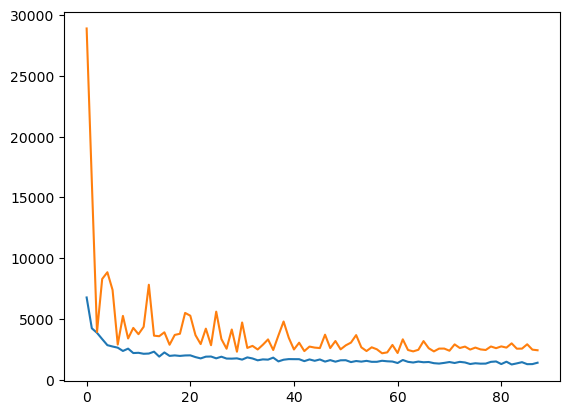

In [32]:
fox = pd.DataFrame(history.history)
fox['loss'].plot()
fox['val_loss'].plot()

In [211]:
def ensemble_model_generator(model):
    X = np.concatenate((X_train_preprocessed,X_val_preprocessed),axis=0)
    y = np.concatenate((y_train_pre,y_val_pre),axis=0)


    models = []
    for i in range(0,3,1):
        sel_X = X[int(i*0.316*X.shape[0]):int((i+1)*0.316*X.shape[0])]
        sel_y = y[int(i*0.316*y.shape[0]):int((i+1)*0.316*y.shape[0])]

        sel_X_val = X[int(i*(0.316+0.05)*X.shape[0]):int((i+1)*(0.316+0.05)*X.shape[0])]
        sel_y_val = y[int(i*(0.316+0.05)*y.shape[0]):int((i+1)*(0.316+0.05)*y.shape[0])]
    
        new_model.fit(sel_X,pd.Series(sel_y),
                epochs=500, batch_size=60,
                validation_data=[sel_X_val, pd.Series(sel_y_val)],
                callbacks=tuner_callback, 
                verbose=True)        
        models.append(new_model)
    models.append(model)
    return models

cv_result = rolling_window_cross_val(model)


Epoch 1/500


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 7149.0820 - val_loss: 1681.5537
Epoch 2/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 861.4919 - val_loss: 1785.5146
Epoch 3/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 760.4055 - val_loss: 1234.1215
Epoch 4/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 849.3683 - val_loss: 1571.2203
Epoch 5/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 852.1205 - val_loss: 1405.9625
Epoch 6/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 856.2928 - val_loss: 1226.5776
Epoch 7/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 1067.5424 - val_loss: 1013.1439
Epoch 8/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 853.8668 - val_loss: 738.9419
Epoch 9/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 696.1080 - val_loss: 1137.3062
Epoch 10/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 859.9547 - val_loss: 1210.5264
Epoch 11/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 961.9218 - val_loss: 827.6744
Epoch 12/500
6/6 ━━━━━━━━━━━━━━

In [217]:
def ensemble(models,X):
    predictions = []
    for i in range(0,len(models),1):
        pred_sel = models[i].predict(X)
        predictions.append(pred_sel)
    output = np.concatenate(predictions)/len(models)
    return pred_sel

In [215]:
TRAIN = ensemble(cv_result, X_train_preprocessed)
VAL = ensemble(cv_result, X_val_preprocessed)
TEST = ensemble(cv_result, X_test_preprocessed)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [173]:
# abba

In [174]:
# plt.plot(abba)
# # plt.show()

In [175]:
# model.fit(X_train_preprocessed, y_train_pre)
# train_pred = model.predict(X_train_preprocessed)
# val_pred = model.predict(X_val_preprocessed)
# test_pred = model.predict(X_test_preprocessed)

<h1> Large  tuner end

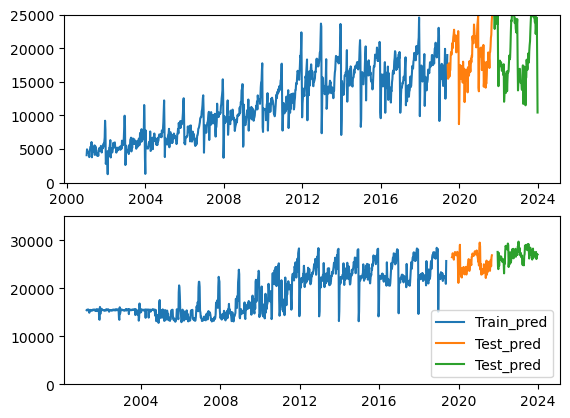

In [218]:
fig,ax = plt.subplots(2)
ax[0].plot(y_train, label='Train')
ax[0].plot(y_val, label='Valid')
ax[0].plot(y_test, label='Test')
ax[0].set_ylim(0,25000)

ax[1].plot(X_train.index[14:], TRAIN, label='Train_pred')
ax[1].plot(X_val.index[14:], VAL, label='Test_pred')
ax[1].plot(X_test.index[14:], TEST, label='Test_pred')
ax[1].set_ylim(0,35000)

plt.legend()
plt.show()

In [185]:
# from sklearn.metrics import root_mean_squared_error as RMSE
# from sklearn.metrics import mean_absolute_percentage_error as 
from sklearn.metrics import mean_absolute_error as MAE


In [190]:
y_train

Date
2001-01-01     4089
2001-01-08     4959
2001-01-15     4610
2001-01-22     4470
2001-01-29     4523
              ...  
2019-04-22    16037
2019-04-29    16133
2019-05-06    16315
2019-05-13    16127
2019-05-20    18992
Name: Salmon_exp_vol, Length: 960, dtype: int64

In [210]:
MAE(y_val_pre, VAL)

6340.21980026533

In [ ]:
1360/11700

0.11623931623931624

<h2> Residual analysis

In [ ]:
# train_pred

In [ ]:
residuals = val_pred.flatten() - y_val_pre

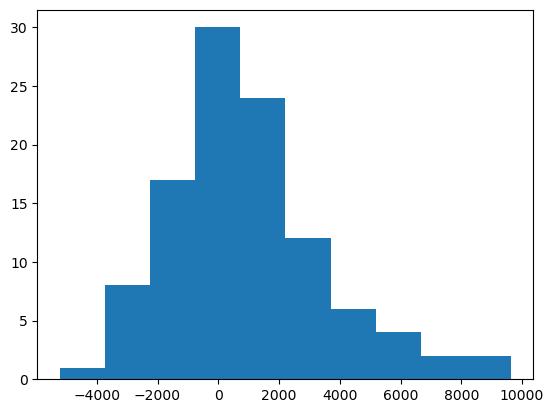

In [ ]:
plt.hist(residuals)
plt.show()

In [ ]:
my = np.mean(residuals)

In [ ]:
std = np.std(residuals)
std

2632.078008660784

In [ ]:
print('lower') 
my- std*1.28

lower


-2487.629868774483

In [ ]:
print('upper') 
my+ std*1.28

upper


2575.9366144584574

In [ ]:
std*100

263207.80086607835

In [ ]:
high_list = []
low_list = []
for i in range(0,len(test_pred),1):
    high_sel = test_pred[i][0] + std*(i+1)
    low_sel = test_pred[i][0] - std*(i+1)
    high_list.append(high_sel)
    low_list.append(low_sel)
    

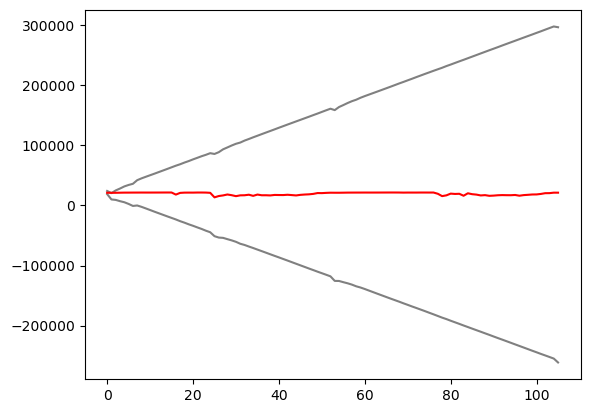

In [ ]:
plt.plot(high_list,color='grey')
plt.plot(low_list, color='grey')
plt.plot(val_pred, color='red')
plt.show()